# inter-run comparisons of N contained in phytoplankton
    - full domain sum
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days
fnum=18 # number of results files per run
runlen=fdur*fnum # length of run in days
#stm=np.shape(tmask)

In [6]:
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
dirnames=('spring2015_NewSink','spring2015_KhT','RateAndHalfSat')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF','Total':'SumAll'}
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        ff[idir][pl]=nc.Dataset(saveloc+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    try:
        pl='Total'
        ff[idir][pl]=nc.Dataset(saveloc+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    except:
        pass

In [7]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00
1900-01-01 00:00:00
1900-01-01 00:00:00


In [14]:
lcol={'spring2015_NewSink':{'diatoms':'darkgreen','flagellates':'mediumblue','ciliates':'maroon'},
      'spring2015_KhT':{'diatoms':'springgreen','flagellates':'dodgerblue','ciliates':'salmon'},
     'RateAndHalfSat':{'diatoms':'c','flagellates':'blueviolet','ciliates':'orange'}}
lsty={'spring2015_NewSink':'-',
      'spring2015_KhT':'-',
      'RateAndHalfSat':'--'}

In [10]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))

In [11]:
sumVarTr={'diatoms':'diatSum','flagellates':'flagSum','ciliates':'myriSum'}

diatSum
flagSum
myriSum
diatSum
flagSum
myriSum


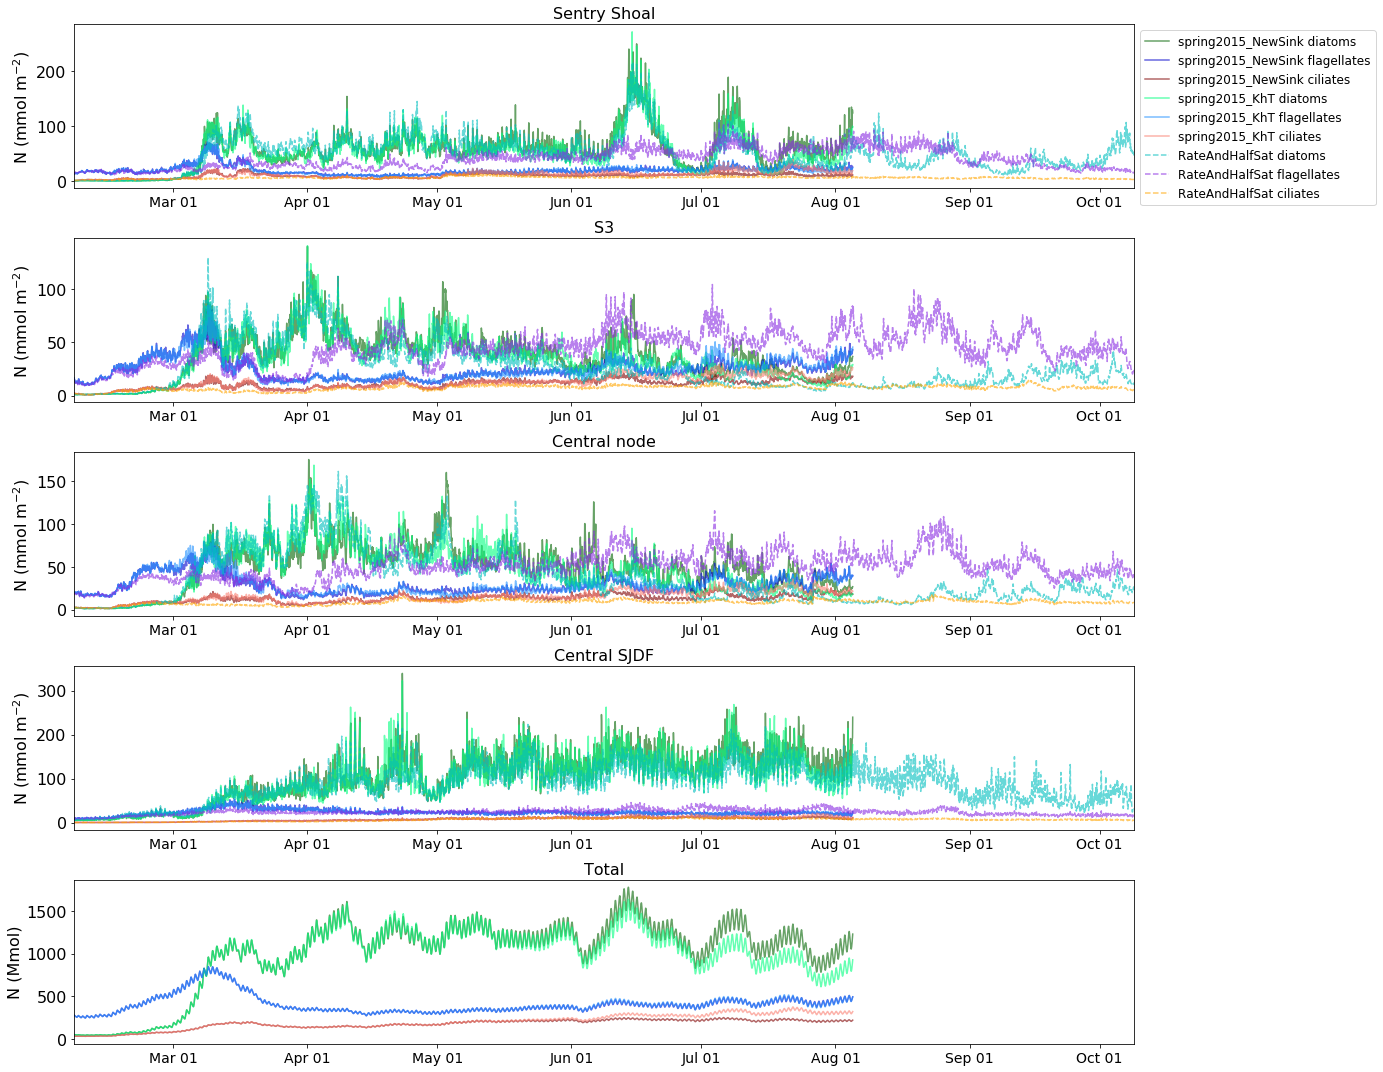

In [15]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist)+1,1,figsize=(16,3*(len(plist)+1)))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    pp[ii]=dict()
    for idir in dirnames:
        f=ff[idir][pl]
        for var in ('diatoms','flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],np.sum(f.variables[var][:,:,0,0]*f.variables['e3t'][:,:,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.6,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],np.sum(f.variables[var][:,:,0,0]*np.tile(e3t_0[:,:,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.6,label=idir+' '+var)
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('N (mmol m$^{-2}$)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)
ii=ii+1
pp[ii]=dict()
for idir in dirnames[0:2]:
    pl='Total'
    f=ff[idir][pl]
    for var in ('diatoms','flagellates','ciliates'):
        print(sumVarTr[var])
        pp[ii][var]=ax[ii].plot(times[idir],1e-9*f.variables[sumVarTr[var]][:],
                      linestyle=lsty[idir], color=lcol[idir][var], alpha=.6, label=idir+' '+var)
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('N (Mmol)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
plt.tight_layout()